<a href="https://colab.research.google.com/github/rhMyCode/Kaggle/blob/main/House-Prices-Advanced-Regression-Techniques/Model_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# House-Prices-Advanced-Regression-Techniques/Model_XGBoost.ipynb

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
#from google.colab import files
#files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Let's make sure the kaggle.json file is present.
#!ls -lha kaggle.json

In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/kaggle.json

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# List available datasets.
!kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023                     Global YouTube Statistics 2023                       60KB  2023-07-28 15:36:38           6978        229  1.0              
claymaker/us-largest-companies                                      us_largest_companies                                  4KB  2023-08-18 17:34:28            470         22  1.0              
nelgiriyewithana/countries-of-the-world-2023                        Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33          14017        553  1.0              
ishanshrivastava28/tata-online-retail-da

In [ ]:
!unzip -o house-prices-advanced-regression-techniques.zip -d train

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: train/data_description.txt  
  inflating: train/sample_submission.csv  
  inflating: train/test.csv          
  inflating: train/train.csv         


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb


In [ ]:
df = pd.read_csv(r"train/train.csv")
df.drop('Id', axis=1, inplace=True)

In [ ]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df.shape

(1460, 80)

In [ ]:
print('total columns:', len(df.columns.tolist()))
sorted(df.columns)

total columns: 80


['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'Alley',
 'BedroomAbvGr',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'EnclosedPorch',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Fireplaces',
 'Foundation',
 'FullBath',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenAbvGr',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotArea',
 'LotConfig',
 'LotFrontage',
 'LotShape',
 'LowQualFinSF',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'Neighborhood',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PavedDrive',
 'PoolArea',
 'PoolQC',
 'RoofMatl',
 'RoofStyle',
 'Sa

In [ ]:
print('columns with numeric data:', len(df.select_dtypes(include=np.number).columns.tolist()))
sorted(df.select_dtypes(include=np.number).columns)

columns with numeric data: 37


['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MSSubClass',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold']

In [ ]:
m = pd.DataFrame(df.isnull().sum(), columns=['count'])
m.rename_axis('name').reset_index(drop=True, inplace=True)

print('columns with missing data:', len(m))
m[m['count'] > 0].sort_values(['count'], ascending=[False])

columns with missing data: 80


,count
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81
GarageQual,81


<Axes: >

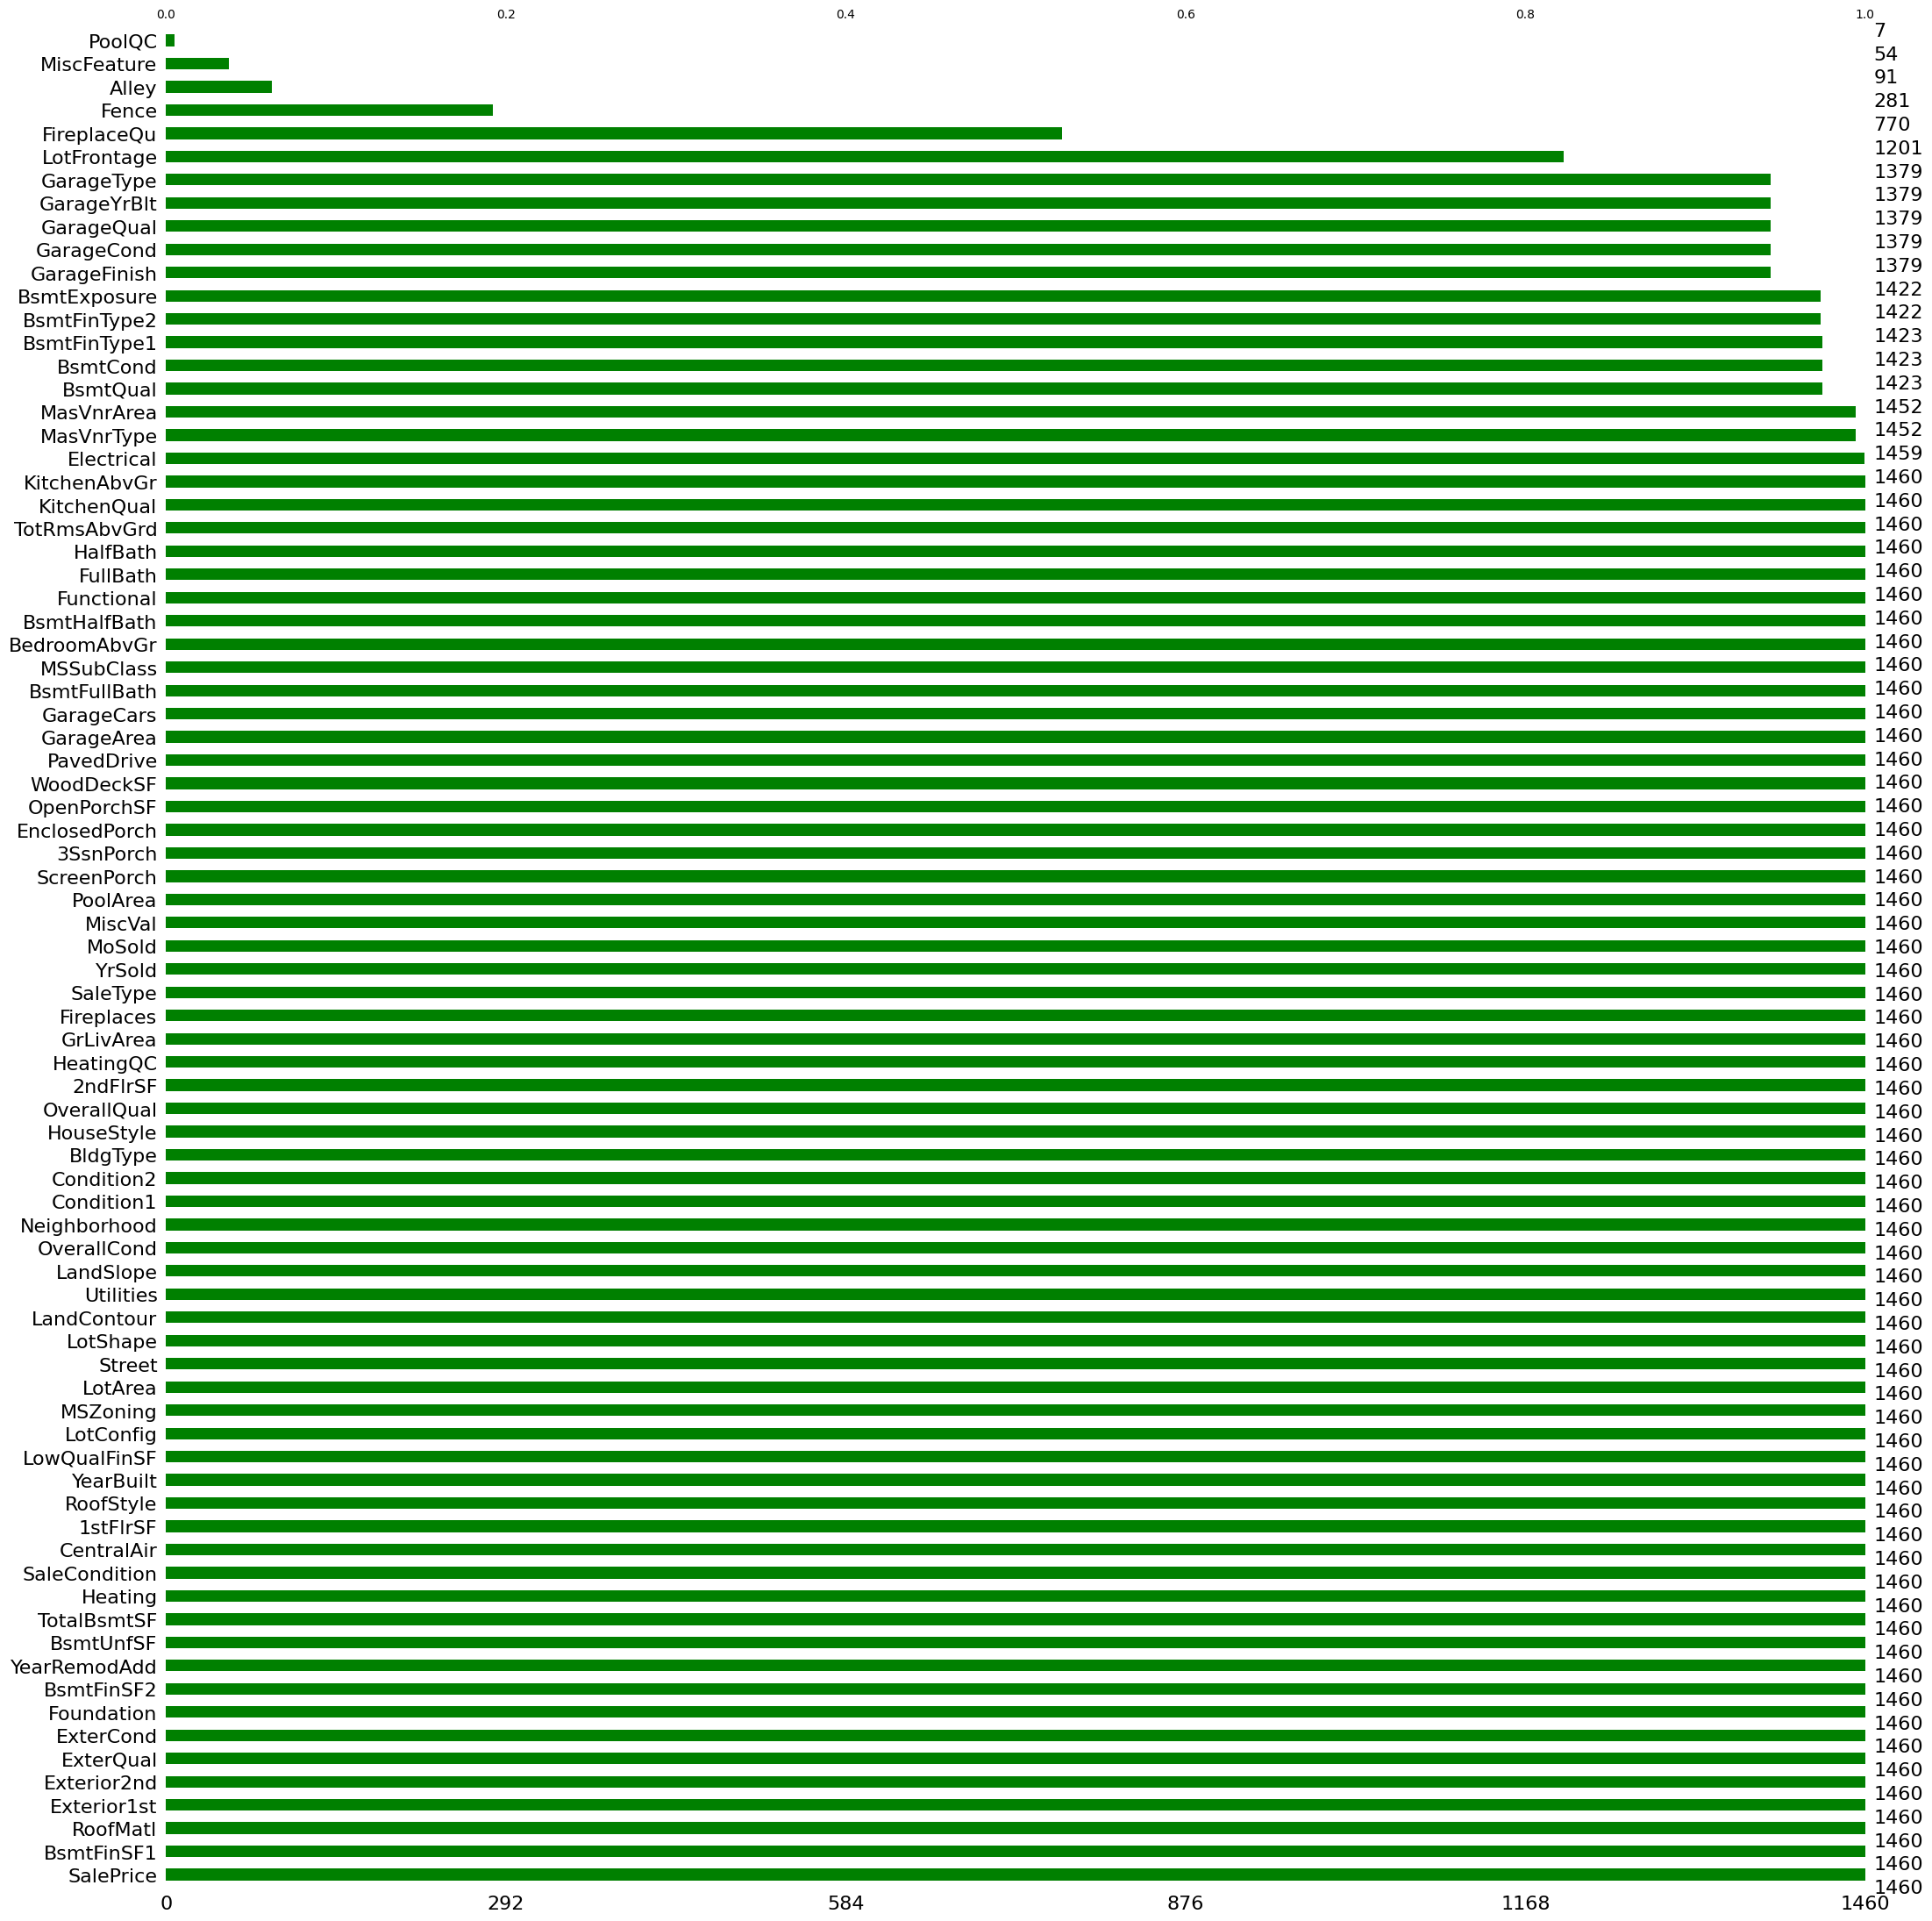

In [ ]:
msno.bar(df, color='green', sort='descending')

In [ ]:
df.drop(['PoolQC','MiscFeature','Alley','Fence'], axis=1, inplace=True)

In [ ]:
n = df.select_dtypes(include=np.number)
n.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


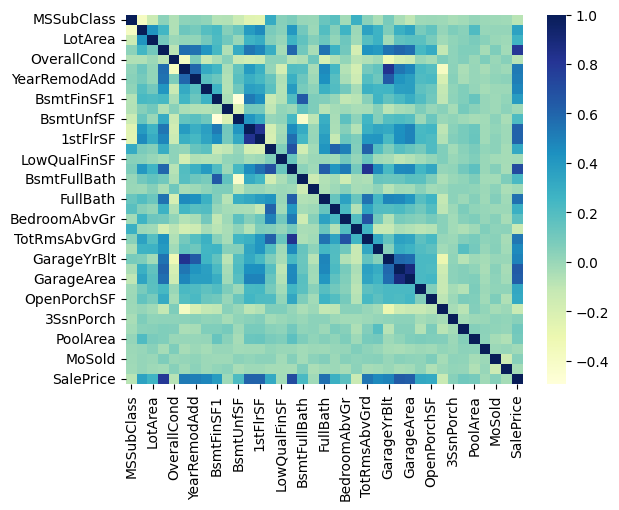

In [ ]:
# not all numerica data is in correlation map ??? -- why ???
dataplot = sns.heatmap(n.corr(), cmap='YlGnBu')
plt.show()

In [ ]:
df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 76, dtype: object

In [ ]:
[df.columns.to_series().groupby(df.dtypes).groups]

[{int64: ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'], float64: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], object: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'Garage

In [ ]:
list(df.select_dtypes(['object']).columns)

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
df_numeric = df[df.select_dtypes(['int64']).columns]
df_numeric = df_numeric.join(df[df.select_dtypes(['float64']).columns])
df_numeric

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,LotFrontage,MasVnrArea,GarageYrBlt
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,0,0,0,2,2008,208500,65.0,196.0,2003.0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0,0,0,0,5,2007,181500,80.0,0.0,1976.0
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,0,0,0,9,2008,223500,68.0,162.0,2001.0
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,0,0,0,2,2006,140000,60.0,0.0,1998.0
4,60,14260,8,5,2000,2000,655,0,490,1145,...,0,0,0,0,12,2008,250000,84.0,350.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0,0,953,953,...,0,0,0,0,8,2007,175000,62.0,0.0,1999.0
1456,20,13175,6,6,1978,1988,790,163,589,1542,...,0,0,0,0,2,2010,210000,85.0,119.0,1978.0
1457,70,9042,7,9,1941,2006,275,0,877,1152,...,0,0,0,2500,5,2010,266500,66.0,0.0,1941.0
1458,20,9717,5,6,1950,1996,49,1029,0,1078,...,0,0,0,0,4,2010,142125,68.0,0.0,1950.0


In [ ]:
df_object = df[df.select_dtypes(['object']).columns]
df_object

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,WD,Normal


In [ ]:
# Create an instance of One-hot-encoder
enc = OneHotEncoder()
enc_data = pd.DataFrame(enc.fit_transform(df_object).toarray())

In [ ]:

df_enc = df_numeric.join(enc_data)
df_enc

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,241,242,243,244,245,246,247,248,249,250
0,60,8450,7,5,2003,2003,706,0,150,856,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,11250,7,5,2001,2002,486,0,434,920,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,9550,7,5,1915,1970,216,0,540,756,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,14260,8,5,2000,2000,655,0,490,1145,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0,0,953,953,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,20,13175,6,6,1978,1988,790,163,589,1542,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,70,9042,7,9,1941,2006,275,0,877,1152,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,20,9717,5,6,1950,1996,49,1029,0,1078,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#mse = np.mean((actual - predicted) ** 2)
#rmse = np.sqrt(mse)
X = df_enc.drop('SalePrice', axis=1)
y = df_enc['SalePrice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=False)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=False)


In [ ]:
# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)
preds = model.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 25151.463


In [ ]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
   X[col] = X[col].astype('category')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:
# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)
preds = model.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 35139.305
